# Лабораторная работа 3: Перенос знаний с использованием PyTorch

**Цель:** изучить и реализовать метод переноса знаний (transfer learning) в глубоких нейронных сетях для решения задачи классификации отходов на основе набора данных [Garbage Classification]
- Предлагается применение метода переноса знаний к известным моделям глубокого обучения, обученных на наборе данных ImageNet.

**Ссылка на набор данных:** https://www.kaggle.com/datasets/asdasdasasdas/garbage-classification

## Перенос знаний

Перенос знаний — это метод, позволяющий улучшить сх модели на новых данных за счет лучшей начальной инициализации модели, а в качестве начальной инициализации выступают веса полученной на исходном наборе данных.
- Этот подход  применяется в з, где  мало данных, но есть смежный набор данных с обученной моделью.
- В задачах классификации этот подход предполагает изм последнего слоя - заменяют на один или несколько слоев, т.к. кол-во нейронов в последнем слое определяется количеством классов в исходном наборе данных. (модель, обученная на ImageNet - 1000 нейронов на последнем слое, а модель на MNIST - 10 нейронов).
- Вместо последнего слоя также можно использовать классические модели машинного обучения  
**!!! НО !!! данный подход нельзя использовать в этой лабораторной работе**

## Подходы к переносу знаний

Любая подобная конфигурация является допустимой и может помочь в решении задачи:
1) Обучение всех весов нейронной сети
2) Обучение весов слоев, которые были добавлены или изменены
3) Обучение нескольких последних слоев
4) Обучение части слоев нейронной сети
- Для определения наилучшей конфигурации - проводятся эксперименты



## Требования
1. Загрузить и проверить данные:  демонстрация изображений и меток классов, совпадение размерностей.
2. Загрузить 4 нейронные сети, обученные на наборе данных ImageNet.  
   2.1. Для каждой модели провести 2 эксперимента, используя разные конфигурация переноса знаний.
    - Модифицировать последний слой -> реализовать обучение на наборе данных Garbage Classification.
    - Настройте гиперпараметры обучения (скорость обучения, количество эпох, размер батча и др.) для каждого эксперимента..
    - Построить F1-score от количества эпох для всех моделей на валидационных данных: покажет, как изменяется F1-score в процессе обучения для каждой   модели и типа эксперимента.
    - Построить сравнительную столбчатую диаграмму точностей: по оси X указываются пары «модель и тип эксперимента», а по оси Y — F1-score на тестовых данных.

- Разделите датасет на тренировочную, валидационную и тестовую выборки самостоятельно в соотношении 70/15/15.
- Для оценки качества следует использовать Macro F1-score, т.к. датасет не сбалансирован.

## Архитектуры:
- Можно использовать любые сверточные архитектуры или архитектуры на базе механизма внимания (transformer, ViT).


## ❗❗❗ Решение

In [1]:
def show_info_abt_architecture(data, num_images=20):
    # Создаем фигуру с сеткой 2x10 для отображения 20 изображений
    fig, axes = plt.subplots(2, 10, figsize=(20, 5))
    fig.suptitle("Sample Images from Dataset", fontsize=16)

    # Выбираем случайные индексы изображений из датасета
    indices = torch.randint(0, len(data), (num_images,))

    for i, ax in enumerate(axes.flat):
        # Получаем изображение и метку по индексу
        img, label = data[indices[i]]

        # Меняем порядок каналов для отображения [C, H, W] -> [H, W, C]
        img = img.permute(1, 2, 0)

        # Обратная нормализация для изображений, если требуется
        img = img * torch.tensor([0.5, 0.5, 0.5]) + torch.tensor([0.5, 0.5, 0.5])
        img = img.clip(0, 1)

        # Отображаем изображение и метку
        ax.imshow(img)
        ax.set_title(f"{data.classes[label]} ({label})")
        ax.axis('off')

    plt.tight_layout()
    plt.subplots_adjust(top=0.85)  # для заголовка
    plt.show()

## ✅ 0. Подключение библиотек

In [2]:
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import torch.nn as nn

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.data import Subset

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import os
import matplotlib.pyplot as plt
from time import time
from collections import Counter

### н.у

In [3]:
learning_rate = 0.001
epochs = 20
batch_size = 64

## ✅ 1. Объект transform для преобразования изображений

1) **Resize**: для согласования с предобученными моделями
2) **ToTensor**: Преобразует изображение (которое обычно представляется в формате numpy-матрицы) в тензор PyTorch,
где значения пикселей нормализованы в диапазон [0, 1].  
3) **Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)):** Нормализует тензор изображения, вычитая среднее значение (заданное первым кортежем) и деля на стандартное отклонение (заданное вторым кортежем): нормализация выполняется для каждого из трёх каналов RGB -> преобразует значения пикселей в диапазон от [-1, 1] (+ часто улучшает обучение нейронных сетей)

In [4]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

## ✅ 2. Загрузка Garbage Classification

In [5]:
# Теперь можно обращаться к файлам на диске, например:
path = 'E:/Garbage Classification/Garbage Classification/Garbage Classification'

class_names = os.listdir(path)
print(class_names)

['cardboard', 'glass', 'metal', 'paper', 'plastic', 'trash']


**Классы:**  **1)** cardboard: картон   **2)** glass: стекло   **3)** metal: метал   **4)** paper: бумага   **5)** plastic: пластик   **6)** trash: мусор  

In [6]:
dataset = datasets.ImageFolder(path, transform = transform)

### 1️⃣ Разделение датасета на тренировочную, валидационную и тестовую выборки в соотношении 70/15/15

1) **DataLoader():** оборачивает набор данных в объект загрузчика данных, который позволяет загружать данные батчами, а также управлять их перемешиванием.  
2) **batch_size**: количество иозображений, которые будут загружены за 1 раз  
3) **shuffle = True:** Этот параметр указывает, что тренировочные данные должны перемешиваться перед каждой эпохой обучения

- **В train_loader/ test_loader/ validation_loader хранятся итераторы,** которые позволяют поочерёдно загружать данные из наборов данных  
- **train_loader.dataset**: набор данных   

In [7]:
# метки
targets = dataset.targets

# проиндексируем изображения
indices = [*range(len(dataset))]

# train_indices: 70%
# stratify=targets: чтобы каждая выборка имела сбалансированное представление всех классов
train_indices, temp_indices = train_test_split(indices, test_size = 0.3, stratify = targets)
targets_remaining_indices = [targets[i] for i in temp_indices]
validation_indices, test_indices = train_test_split(temp_indices, test_size = 0.5, stratify = targets_remaining_indices)

train_dataset = Subset(dataset, train_indices)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)

validation_dataset = Subset(dataset, validation_indices)
validation_loader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)

test_dataset = Subset(dataset, test_indices)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

## ✅ 3. Проверка данных

### 1️⃣ Проверим размерность

#### Количество данных

In [8]:
# Количество изображений
num_images = len(dataset.imgs)
print(f"Количество изображений: {num_images}")

# Количество меток
num_targets = len(dataset.targets)
print(f"Количество меток: {num_targets}")

Количество изображений: 2527
Количество меток: 2527


#### Размерность

In [9]:
# Получаем первое изображение и его метку
sample_image, _ = dataset[0]

# Проверяем размерность изображения  [C, H, W]
image_shape = sample_image.shape
print(f"Размер изображения: {image_shape}")

Размер изображения: torch.Size([3, 224, 224])


In [10]:
print(len(train_dataset))
print(len(test_dataset))
print(len(validation_dataset))

1768
380
379


In [11]:
# Подсчет уникальных меток
unique_labels = set(dataset.targets)
num_unique_labels = len(unique_labels)
print(f"Количество уникальных меток: {num_unique_labels}")

Количество уникальных меток: 6


**Классы:**  **1)** cardboard: картон   **2)** glass: стекло   **3)** metal: метал   **4)** paper: бумага   **5)** plastic: пластик   **6)** trash: мусор  

### 2️⃣ Вывод изображений и меток

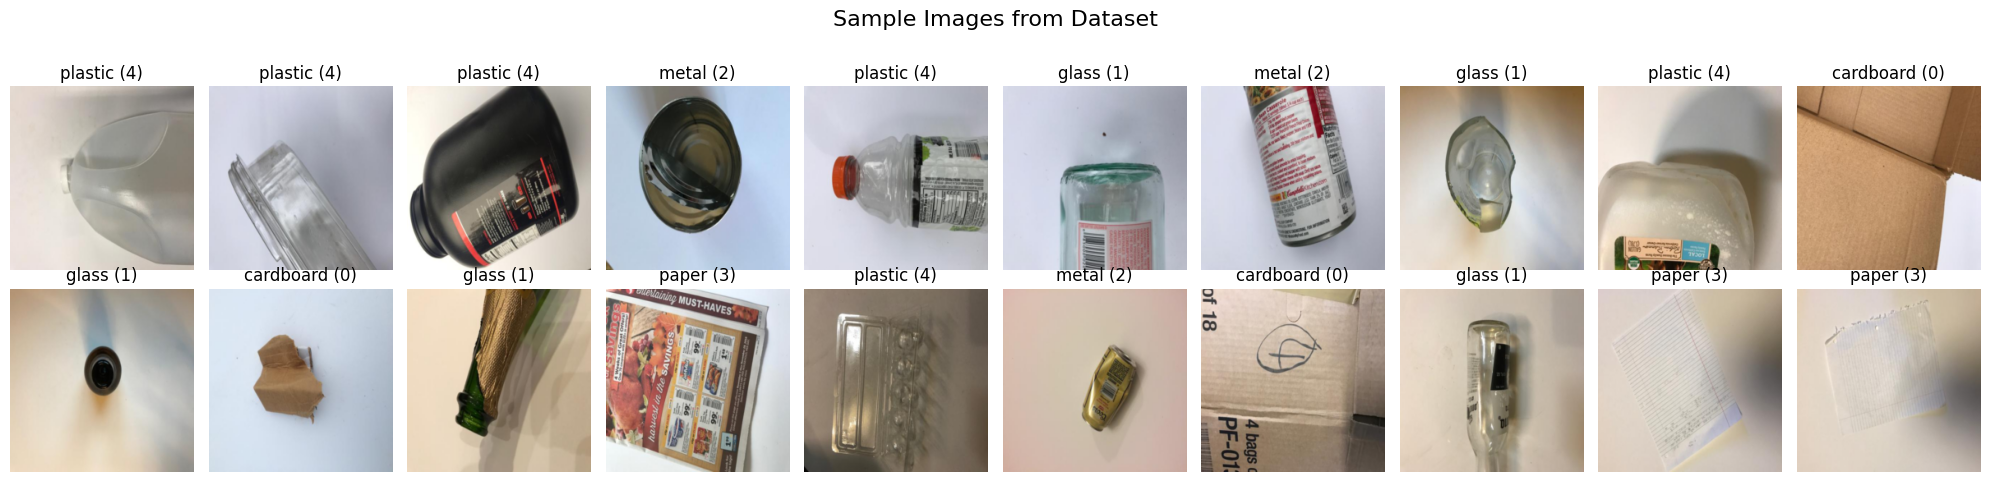

In [12]:
show_info_abt_architecture(dataset)

## ✅ 4. Архитектуры

1) ResNet-50
- classic: Обучение всех весов нейронной сети
- modification: Обучается только добавленный слой
3) MobileNetV2
- classic: Обучение всех весов нейронной сети
- modification: Обучается добавленный блок в конце.
4) EfficientNet-B0
- classic: Обучение всех весов нейронной сети
- modification: Обучается только новый классификатор 
5) Densenet-121
  - classic: Обучение всех весов нейронной сети
- modification: Обучаются несколько последних слоев, включая классификатор

### 1️⃣ ResNet-50

**resnet50_classic:**  
❗ **Обучение всех весов нейронной сети**  
**'#'** В torchvision использование ImageNet для предобученных весов моделей — это стандарт

**resnet50_modified:**   
❗ **Используется обучение только добавленных или измененных слоев.**  
Все параметры исходной модели заморожены (предотвращает их обновление во время обучения): param.requires_grad = False  

**'#'** Заморозка параметров помогает сохранить знания, которые модель получила при обучении на ImageNet

**1)** Dropout (0.5) помогает предотвратить переобучение модели за счет случайного "выключения" половины нейронов на каждой итерации обучения, что заставляет модель не полагаться слишком сильно на отдельные признаки  
**2)** nn.Linear(model.fc.in_features, 512) eменьшает количество признаков, полученных с предыдущих слоев, до 512 -> уменьшает сложность  
**3)** nn.ReLU() введения нелинейности в модель -> позволяет нейронной сети моделировать сложные зависимости между признаками.  
**4)** nn.Linear(512, num_classes)  итоговая классификацая на основе признаков, выделенных предыдущими слоями: уменьшает размерность до требуемого   числа классов


In [ ]:
def resnet50(num_classes: int, modified: bool = False):
    # Загрузка предобученной модели ResNet-50 с весами, которые были обучены на наборе данных ImageNet.
    model = models.resnet50(weights = models.ResNet50_Weights.DEFAULT)

    if not modified:
        # Классическая версия: замена только последнего слоя fc для классификации, который уже умеет распознавать общие визуальные признаки.
        model.fc = nn.Linear(model.fc.in_features, num_classes)  
    else:
        # # Цикл: все параметры модели устанавливаются не обучаемые (замораживаем все параметры модели)
        for param in model.parameters():
            param.requires_grad = False
            
        # Замена последнего слоя на новый классификационный блок
        model.fc = nn.Sequential(
            nn.Dropout(0.5),                          # Dropout (для регуляризации)
            nn.Linear(model.fc.in_features, 512),     # линейный слоя
            nn.ReLU(),                                # ф. активации ReLU
            nn.Linear(512, num_classes),)             # линейный слоя (для финальной классификации)
       
    return model

### 2️⃣ MobileNetV2

**mobilenet_v2_classic:**  
❗ **Обучение всех весов нейронной сети**


**mobilenet_v2_modified:**   
❗ **Обучение только новых слоев**  


**'#'** Заморозка: перенос знаний будет касаться только новых слоев 

Новый сверточный блок добавляется для улучшения способности модели адаптироваться к новым данным  
**1)** nn.Conv2d(in_channels=1280, out_channels=512, kernel_size=3, padding=1): уменьшение числа каналов -> уменьшает ложность модели  
**2)** nn.BatchNorm2d(512) стабилизирует обучение, нормализуя активации на каждом слое  
**3)** ReLU активация добавляет нелинейность, позволяет нейронной сети моделировать сложные зависимости между признаками.  

**1)** Dropout (0.5) применяется для регуляризации, что помогает предотвратить переобучение модели  
**2)** nn.Linear(512, num_classes) линейный слой с 512 входами и num_classes выходами  

In [2]:
def mobilenet_v2(num_classes: int, modified: bool = False):
    # Загрузка модели MobileNet v2 с предобученными весами на ImageNet
    model = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.DEFAULT)

    if not modified:
        # model.classifier[1]: последний слой классификатора в MobileNet v2, который изначально настроен на классификацию 1000 классов.
        # Заменяет его на линейный слой, соответствующий количеству классов в новом наборе данных:
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
    
    else:
        # Замораживает все веса модели MobileNet v2, оставляя их неизменными в процессе обучения
        for param in model.parameters():
            param.requires_grad = False

        # Добавление нового сверточного блока в последнем сверточном слое
        conv_block = nn.Sequential(
            nn.Conv2d(in_channels=1280, out_channels = 512, kernel_size = 3, padding = 1),
            nn.BatchNorm2d(512),
            nn.ReLU(),)
        old_feature = model.features[-1]
        model.features[-1] = nn.Sequential(old_feature, conv_block)

        # Изменение блока классификации:
        model.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(512, num_classes),)
      
    return model

### 3️⃣ EfficientNet-B0

**efficientnet_b0_classic:**   
❗ **Обучение только новых слоев**  

**efficientnet_b0_modified:**   
❗ **Обучение только новых слоев**  

In [3]:
def efficientnet_b0(num_classes: int, modified: bool = False):
    # Загружается предобученная версия модели и инициализируется с весами, предобученными на ImageNet.
    model = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.DEFAULT)

    if not modified:
        # model.classifier[1] последний слой, предназначенный для классификации -> заменяется на новый линейный слой с выходным размером num_classes 
        model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

    else:
        # Замораживаем все параметры модели
        for param in model.parameters():
            param.requires_grad = False
        # Замена классификатора на новый блок с несколькими слоями
        model.classifier = nn.Sequential(
            nn.Dropout(p = 0.5),
            nn.Linear(model.classifier[1].in_features, 512),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Dropout(p = 0.5),
            nn.Linear(512, num_classes),)
      
    return model

### 4️⃣ Densenet-121

**densenet121_classic:**   
❗ **Обучение только новых слоев**  

**densenet121_modified:**   
❗ **Обучение нескольких последних слоев**  

In [16]:
def densenet121(num_classes: int, modified: bool = False):
    # Загружаем предобученную модель DenseNet121 с весами ImageNet
    model = models.densenet121(weights=models.DenseNet121_Weights.DEFAULT)

    if modified:
        # Заморожены первые 6 слоя и 12 параметров, а остальные слои и классификатор остаются доступными для обучения.
        # Обучаются несколько последних слоев модели DenseNet121, включая классификатор.
        for i, param in enumerate(model.parameters()):
            if i < 18:
                param.requires_grad = False

    # Заменяем классификатор на новый линейный слой для нужного количества классов
    model.classifier = nn.Linear(model.classifier.in_features, num_classes)

    return model

## ✅ 5. F1score, train, experiment

### 1️⃣ Объект, который указывает, на каком устройстве будут выполняться вычисления.

In [17]:
# объект, который указывает, на каком устройстве будут выполняться вычисления.
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


### 2️⃣ Функция для оценки F1-score на наборе данных

In [18]:
# отключает градиенты, т.к. в процессе оценки обратное распространение не требуется
@torch.no_grad()
def Calculate_F1score(model, dataloader: DataLoader):
    device = next(model.parameters()).device

    F1_arr = []

    # Модель переводится в режим eval(), чтобы отключить слои, влияющие на поведение при обучении, например: Dropout или BatchNorm.
    model.eval()

    # Для каждого батча из dataloader вычисляем предсказания модели (y) и сравниваем с истинными метками (labels)
    for images, labels in dataloader:
        images, labels = images.to(device), labels.to(device)

        u = model(images)
        _, y = torch.max(u, 1)

        F1_cur = f1_score(labels.cpu(), y.cpu(), average = "macro")
        F1_arr.append(F1_cur)

    # усреденение по всем batch
    return sum(F1_arr) / len(F1_arr)

### 3️⃣ Функция для обучения модели

In [19]:
def Train_one_epoch(model, train_loader, optimizer, criterion, device):
    # Устанавливает модель в режим обучения, чтобы включить слои, которые зависят от этого режима, например: Dropout или BatchNorm.
    model.train()

    st_time = time()
    # Цикл по батчам
    for images, labels in train_loader:
        # Перемещение данных на устройство
        images, labels = images.to(device), labels.to(device)

        # Обнуляет накопленные градиенты с для каждой новой итерации
        optimizer.zero_grad()
        # Прямой проход: пропускает входные данные через модель и получает выходные предсказания
        u = model(images)

        # Вычисление ошибки
        loss = criterion(u, labels)

        # Обратное распространение ошибки
        loss.backward()

        # Обновляет параметры модели, используя оптимизатор,  что позволяет модели обучаться на этом батче данных.
        optimizer.step()

    fn_time = time()

    train_time = fn_time - st_time
    print(f"Время обучения: {train_time:.2f} сек", flush = True)

### 4️⃣  Оценка модели на валидационном наборе данных

**Сохраняет** лучшую модель, если F1-оценка улучшилась.

In [20]:
def Calculate_F1_validation(model, validation_loader, name, best_f1):
    # Вычисление F1-оценки на валидационном наборе данных.
    # Получаем F1-score для всей выборки.
    st_time = time()
    F1_cur = Calculate_F1score(model, validation_loader)
    fn_time = time()

    validation_time = fn_time - st_time

    if F1_cur > best_f1:
        torch.save(model.state_dict(), f"best_{name}.pth")
        print(f"Новая наилучшая модель сохр с F1-score: {F1_cur:.2f}", flush = True)

    print(f"Время валидации: {validation_time:.2f} сек, F1-validation: {F1_cur:.2f}\n")

    return F1_cur

### 5️⃣  Функция для процесса обучения и валидации

In [21]:
def Train_model_with_validation(model, name, train_loader, val_loader, num_epochs, learning_rate):
    # Определяет устройство, на котором находятся параметры модели
    device = next(model.parameters()).device

    # Инициализирует оптимизатор Adam, который обновляет параметры модели, для которых требуется градиент.
    optimizer = torch.optim.Adam(filter(lambda param: param.requires_grad, model.parameters()), lr = learning_rate)
    # Определяет функцию потерь
    criterion = nn.CrossEntropyLoss()

    best_f1 = 0.0
    F1_validation_arr = []

    # Для каждой эпохи (от 0 до num_epochs)
    for epoch in range(num_epochs):
        print(f"Эпоха {epoch + 1}:")

        Train_one_epoch(model, train_loader, optimizer, criterion, device)
        # F1-оценка текущей эпохи.
        F1_cur = Calculate_F1_validation(model, val_loader, name, best_f1)

        F1_validation_arr.append(F1_cur)
        best_f1 = max(best_f1, F1_cur)

    return F1_validation_arr

### 6️⃣ Функция проведения эксперимента

In [22]:
F1_test_arr = {}

def Run_experiment_architecture(architecture, modified = False):
    global F1_test_arr

    # Создание модели:
    model = architecture(len(class_names), modified = modified).to(device) # Получили экземпляр модели
    name = f"{architecture.__name__}_{'modified' if modified else 'classic'}"

    F1_validation_arr = Train_model_with_validation(model, name, train_loader, validation_loader, epochs, learning_rate)

    # Загружает параметры лучшей модели, сохранённой во время обучения, из файла f"best_{name}.pth".
    model.load_state_dict(torch.load(f"best_{name}.pth", weights_only = True))
    # Вычисляет F1-score на тестовом наборе данных
    F1_cur_test = Calculate_F1score(model, test_loader)
    print("F1 test:", F1_cur_test)

    plt.plot(range(epochs), F1_validation_arr, marker="o")
    plt.title(f"{name} validation")
    plt.xlabel("epoch")
    plt.xticks([i for i in range(epochs)])
    plt.ylabel("F1 score")
    plt.ylim(0, 1)
    plt.grid()
    plt.show()

    F1_test_arr[name] = F1_cur_test

## ✅ 6. Эксперименты

Эпоха 1:
Время обучения: 17.06 сек
Новая наилучшая модель сохр с F1-score: 0.45
Время валидации: 2.22 сек, F1-validation: 0.45

Эпоха 2:
Время обучения: 16.10 сек
Новая наилучшая модель сохр с F1-score: 0.72
Время валидации: 2.20 сек, F1-validation: 0.72

Эпоха 3:
Время обучения: 16.13 сек
Новая наилучшая модель сохр с F1-score: 0.73
Время валидации: 2.18 сек, F1-validation: 0.73

Эпоха 4:
Время обучения: 16.15 сек
Новая наилучшая модель сохр с F1-score: 0.76
Время валидации: 2.18 сек, F1-validation: 0.76

Эпоха 5:
Время обучения: 16.15 сек
Новая наилучшая модель сохр с F1-score: 0.81
Время валидации: 2.19 сек, F1-validation: 0.81

Эпоха 6:
Время обучения: 16.13 сек
Время валидации: 2.15 сек, F1-validation: 0.76

Эпоха 7:
Время обучения: 16.14 сек
Новая наилучшая модель сохр с F1-score: 0.84
Время валидации: 2.16 сек, F1-validation: 0.84

Эпоха 8:
Время обучения: 16.16 сек
Время валидации: 2.22 сек, F1-validation: 0.76

Эпоха 9:
Время обучения: 16.17 сек
Время валидации: 2.19 сек, F1-v

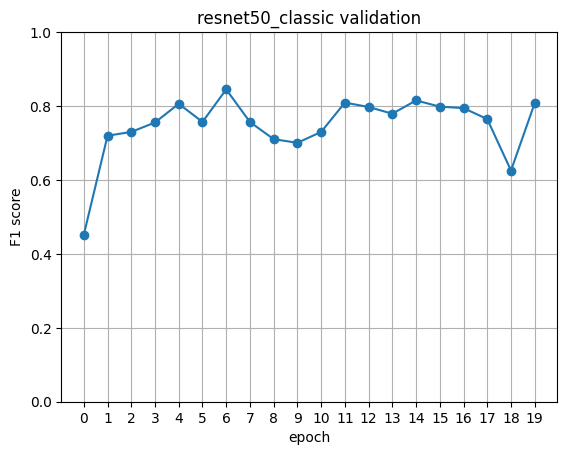

In [23]:
Run_experiment_architecture(resnet50)

Эпоха 1:
Время обучения: 5.40 сек
Новая наилучшая модель сохр с F1-score: 0.74
Время валидации: 1.97 сек, F1-validation: 0.74

Эпоха 2:
Время обучения: 5.25 сек
Новая наилучшая модель сохр с F1-score: 0.79
Время валидации: 1.98 сек, F1-validation: 0.79

Эпоха 3:
Время обучения: 5.37 сек
Новая наилучшая модель сохр с F1-score: 0.82
Время валидации: 2.00 сек, F1-validation: 0.82

Эпоха 4:
Время обучения: 5.25 сек
Новая наилучшая модель сохр с F1-score: 0.84
Время валидации: 2.12 сек, F1-validation: 0.84

Эпоха 5:
Время обучения: 5.48 сек
Новая наилучшая модель сохр с F1-score: 0.85
Время валидации: 2.18 сек, F1-validation: 0.85

Эпоха 6:
Время обучения: 5.44 сек
Время валидации: 1.99 сек, F1-validation: 0.84

Эпоха 7:
Время обучения: 5.25 сек
Новая наилучшая модель сохр с F1-score: 0.85
Время валидации: 2.01 сек, F1-validation: 0.85

Эпоха 8:
Время обучения: 5.25 сек
Время валидации: 2.00 сек, F1-validation: 0.84

Эпоха 9:
Время обучения: 5.25 сек
Время валидации: 1.99 сек, F1-validation

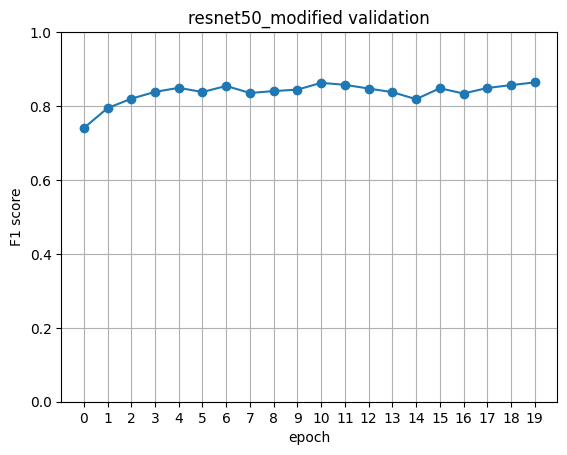

In [24]:
Run_experiment_architecture(resnet50, modified = True)

Эпоха 1:
Время обучения: 8.34 сек
Новая наилучшая модель сохр с F1-score: 0.81
Время валидации: 1.35 сек, F1-validation: 0.81

Эпоха 2:
Время обучения: 7.88 сек
Новая наилучшая модель сохр с F1-score: 0.85
Время валидации: 1.39 сек, F1-validation: 0.85

Эпоха 3:
Время обучения: 7.91 сек
Время валидации: 1.40 сек, F1-validation: 0.81

Эпоха 4:
Время обучения: 7.88 сек
Новая наилучшая модель сохр с F1-score: 0.86
Время валидации: 1.41 сек, F1-validation: 0.86

Эпоха 5:
Время обучения: 7.90 сек
Время валидации: 1.38 сек, F1-validation: 0.83

Эпоха 6:
Время обучения: 7.90 сек
Время валидации: 1.37 сек, F1-validation: 0.84

Эпоха 7:
Время обучения: 7.89 сек
Время валидации: 1.40 сек, F1-validation: 0.82

Эпоха 8:
Время обучения: 7.87 сек
Новая наилучшая модель сохр с F1-score: 0.88
Время валидации: 1.37 сек, F1-validation: 0.88

Эпоха 9:
Время обучения: 7.88 сек
Время валидации: 1.37 сек, F1-validation: 0.84

Эпоха 10:
Время обучения: 7.89 сек
Время валидации: 1.39 сек, F1-validation: 0.83


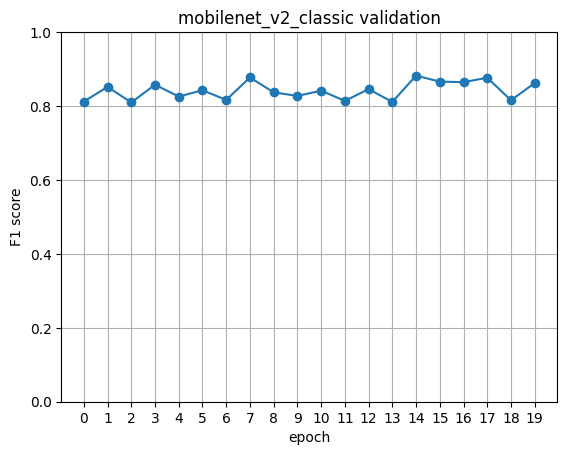

In [25]:
Run_experiment_architecture(mobilenet_v2)

Эпоха 1:
Время обучения: 4.71 сек
Новая наилучшая модель сохр с F1-score: 0.81
Время валидации: 1.41 сек, F1-validation: 0.81

Эпоха 2:
Время обучения: 4.72 сек
Новая наилучшая модель сохр с F1-score: 0.83
Время валидации: 1.43 сек, F1-validation: 0.83

Эпоха 3:
Время обучения: 4.74 сек
Новая наилучшая модель сохр с F1-score: 0.85
Время валидации: 1.39 сек, F1-validation: 0.85

Эпоха 4:
Время обучения: 4.72 сек
Новая наилучшая модель сохр с F1-score: 0.86
Время валидации: 1.40 сек, F1-validation: 0.86

Эпоха 5:
Время обучения: 4.75 сек
Время валидации: 1.39 сек, F1-validation: 0.84

Эпоха 6:
Время обучения: 4.68 сек
Время валидации: 1.40 сек, F1-validation: 0.84

Эпоха 7:
Время обучения: 4.70 сек
Время валидации: 1.39 сек, F1-validation: 0.83

Эпоха 8:
Время обучения: 4.73 сек
Время валидации: 1.39 сек, F1-validation: 0.82

Эпоха 9:
Время обучения: 4.74 сек
Время валидации: 1.42 сек, F1-validation: 0.84

Эпоха 10:
Время обучения: 4.76 сек
Время валидации: 1.41 сек, F1-validation: 0.83


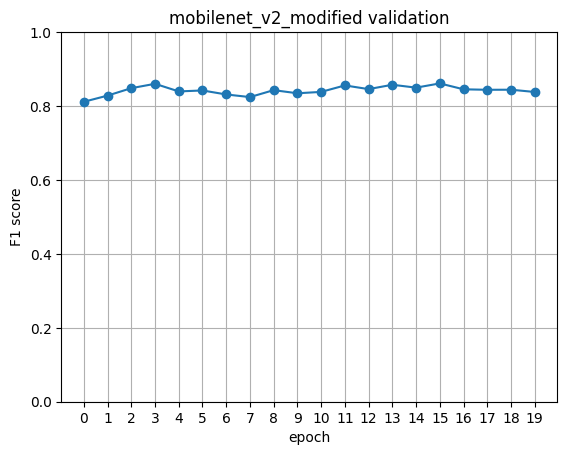

In [26]:
Run_experiment_architecture(mobilenet_v2, modified = True)

Эпоха 1:
Время обучения: 10.48 сек
Новая наилучшая модель сохр с F1-score: 0.80
Время валидации: 1.51 сек, F1-validation: 0.80

Эпоха 2:
Время обучения: 10.43 сек
Новая наилучшая модель сохр с F1-score: 0.88
Время валидации: 1.52 сек, F1-validation: 0.88

Эпоха 3:
Время обучения: 10.41 сек
Новая наилучшая модель сохр с F1-score: 0.88
Время валидации: 1.54 сек, F1-validation: 0.88

Эпоха 4:
Время обучения: 10.42 сек
Время валидации: 1.52 сек, F1-validation: 0.85

Эпоха 5:
Время обучения: 10.42 сек
Время валидации: 1.54 сек, F1-validation: 0.84

Эпоха 6:
Время обучения: 10.43 сек
Время валидации: 1.52 сек, F1-validation: 0.85

Эпоха 7:
Время обучения: 10.44 сек
Время валидации: 1.51 сек, F1-validation: 0.87

Эпоха 8:
Время обучения: 10.42 сек
Время валидации: 1.60 сек, F1-validation: 0.88

Эпоха 9:
Время обучения: 10.45 сек
Время валидации: 1.51 сек, F1-validation: 0.87

Эпоха 10:
Время обучения: 10.44 сек
Время валидации: 1.50 сек, F1-validation: 0.88

Эпоха 11:
Время обучения: 10.45 се

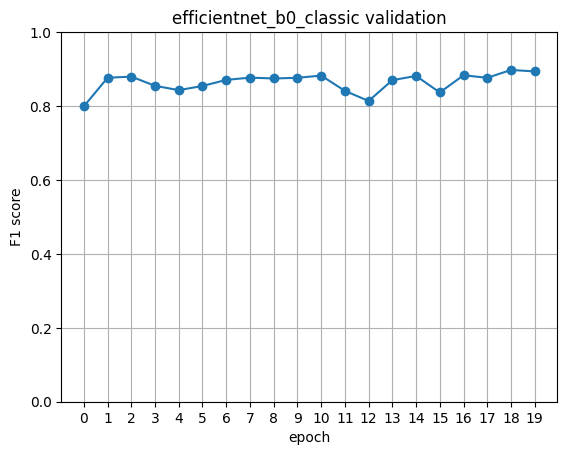

In [27]:
Run_experiment_architecture(efficientnet_b0)

Эпоха 1:
Время обучения: 4.91 сек
Новая наилучшая модель сохр с F1-score: 0.72
Время валидации: 1.48 сек, F1-validation: 0.72

Эпоха 2:
Время обучения: 4.82 сек
Новая наилучшая модель сохр с F1-score: 0.73
Время валидации: 1.49 сек, F1-validation: 0.73

Эпоха 3:
Время обучения: 4.80 сек
Новая наилучшая модель сохр с F1-score: 0.76
Время валидации: 1.48 сек, F1-validation: 0.76

Эпоха 4:
Время обучения: 4.81 сек
Новая наилучшая модель сохр с F1-score: 0.78
Время валидации: 1.48 сек, F1-validation: 0.78

Эпоха 5:
Время обучения: 4.78 сек
Время валидации: 1.48 сек, F1-validation: 0.76

Эпоха 6:
Время обучения: 4.77 сек
Время валидации: 1.49 сек, F1-validation: 0.76

Эпоха 7:
Время обучения: 4.82 сек
Время валидации: 1.49 сек, F1-validation: 0.77

Эпоха 8:
Время обучения: 4.78 сек
Новая наилучшая модель сохр с F1-score: 0.78
Время валидации: 1.48 сек, F1-validation: 0.78

Эпоха 9:
Время обучения: 4.88 сек
Время валидации: 1.47 сек, F1-validation: 0.77

Эпоха 10:
Время обучения: 4.80 сек
Вр

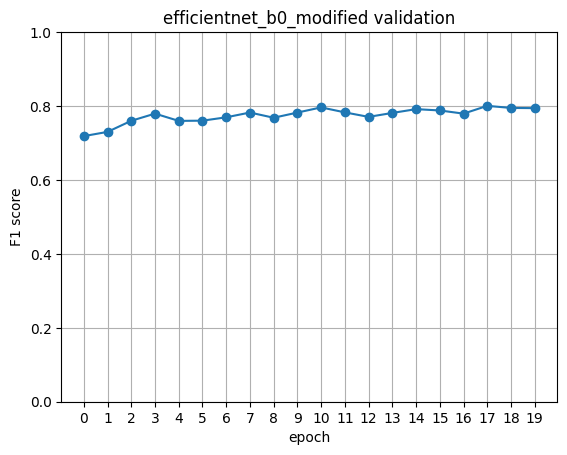

In [28]:
Run_experiment_architecture(efficientnet_b0, modified = True)

Эпоха 1:
Время обучения: 90.05 сек
Новая наилучшая модель сохр с F1-score: 0.69
Время валидации: 5.82 сек, F1-validation: 0.69

Эпоха 2:
Время обучения: 85.47 сек
Время валидации: 5.92 сек, F1-validation: 0.68

Эпоха 3:
Время обучения: 85.38 сек
Новая наилучшая модель сохр с F1-score: 0.77
Время валидации: 5.89 сек, F1-validation: 0.77

Эпоха 4:
Время обучения: 84.12 сек
Новая наилучшая модель сохр с F1-score: 0.80
Время валидации: 5.92 сек, F1-validation: 0.80

Эпоха 5:
Время обучения: 85.46 сек
Новая наилучшая модель сохр с F1-score: 0.81
Время валидации: 5.93 сек, F1-validation: 0.81

Эпоха 6:
Время обучения: 85.48 сек
Время валидации: 5.91 сек, F1-validation: 0.76

Эпоха 7:
Время обучения: 85.46 сек
Время валидации: 5.93 сек, F1-validation: 0.80

Эпоха 8:
Время обучения: 86.08 сек
Время валидации: 7.09 сек, F1-validation: 0.77

Эпоха 9:
Время обучения: 85.67 сек
Время валидации: 5.90 сек, F1-validation: 0.79

Эпоха 10:
Время обучения: 85.50 сек
Новая наилучшая модель сохр с F1-scor

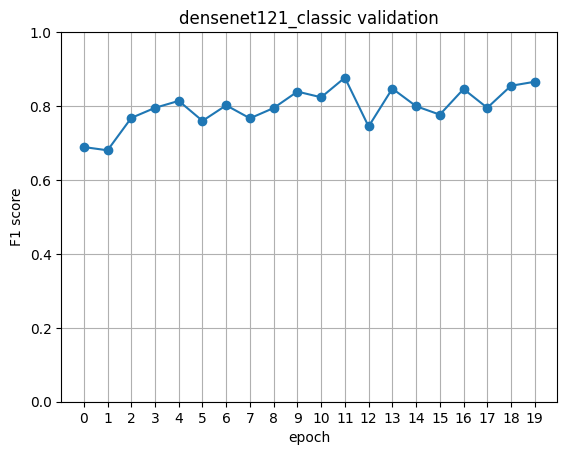

In [29]:
Run_experiment_architecture(densenet121)

Эпоха 1:
Время обучения: 58.67 сек
Новая наилучшая модель сохр с F1-score: 0.66
Время валидации: 10.53 сек, F1-validation: 0.66

Эпоха 2:
Время обучения: 62.85 сек
Новая наилучшая модель сохр с F1-score: 0.78
Время валидации: 10.54 сек, F1-validation: 0.78

Эпоха 3:
Время обучения: 58.66 сек
Время валидации: 10.51 сек, F1-validation: 0.77

Эпоха 4:
Время обучения: 58.82 сек
Время валидации: 10.51 сек, F1-validation: 0.77

Эпоха 5:
Время обучения: 58.71 сек
Новая наилучшая модель сохр с F1-score: 0.82
Время валидации: 10.54 сек, F1-validation: 0.82

Эпоха 6:
Время обучения: 58.70 сек
Время валидации: 10.51 сек, F1-validation: 0.76

Эпоха 7:
Время обучения: 59.47 сек
Новая наилучшая модель сохр с F1-score: 0.83
Время валидации: 10.52 сек, F1-validation: 0.83

Эпоха 8:
Время обучения: 58.72 сек
Новая наилучшая модель сохр с F1-score: 0.87
Время валидации: 10.51 сек, F1-validation: 0.87

Эпоха 9:
Время обучения: 58.69 сек
Новая наилучшая модель сохр с F1-score: 0.87
Время валидации: 10.58 

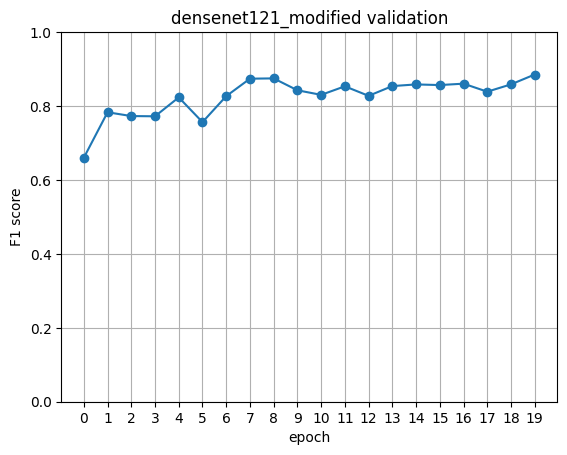

In [30]:
Run_experiment_architecture(densenet121, modified = True)

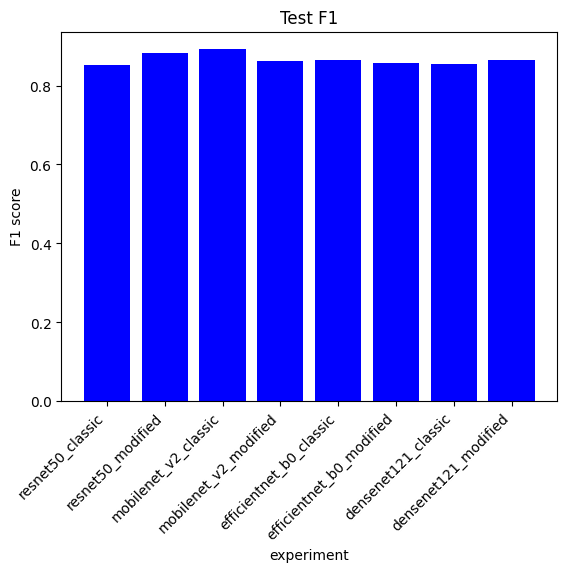

In [31]:
model_names = [*F1_test_arr.keys()]
f1_scores = [*F1_test_arr.values()]
plt.bar(model_names, f1_scores, color = "blue")
plt.xlabel("experiment")
plt.ylabel("F1 score")
plt.title("Test F1")
plt.xticks(rotation = 45, ha = "right")
plt.show()

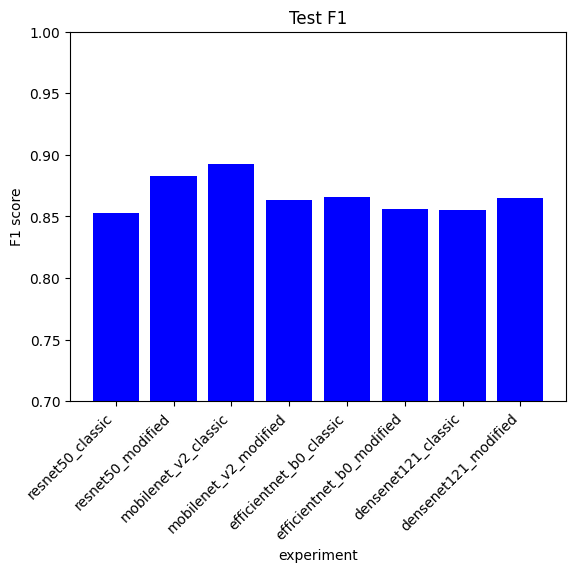

In [32]:
model_names = [*F1_test_arr.keys()]
f1_scores = [*F1_test_arr.values()]
plt.bar(model_names, f1_scores, color = "blue")
plt.xlabel("experiment")
plt.ylabel("F1 score")
plt.title("Test F1")
plt.xticks(rotation = 45, ha = "right")
plt.ylim(0.7, 1)
plt.show()